# Testing
### Wohnflächenpreise (Median) der im Freihandkauf umgesetzten Wohnungen im Stockwerkeigentum nach Stadtquartier, seit 2009

Diese Daten beinhalten die Medianpreise pro Quadratmeter Wohnfläche von im Freihandkauf gehandelten Wohnungen im Stockwerkeigentum in der Stadt Zürich nach Handänderungsjahr und Stadtquartier.

Datum: 03.02.2022

### Importiere die notwendigen Packages

In [4]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [5]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [6]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [7]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [8]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=7, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=38, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [9]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_hae_preis_stwe_whg_quartier_seit2009_od5151

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stwe_whg_quartier_seit2009_od5151


In [10]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int";
print(status)

int


In [11]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stwe_whg_quartier_seit2009_od5151/download/BAU515OD5151.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_hae_preis_stwe_whg_quartier_seit2009_od5151\BAU515OD5151.csv"   

print(fp)

\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_hae_preis_stwe_whg_quartier_seit2009_od5151\BAU515OD5151.csv


In [12]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['Jahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [13]:
#data2betested.head(6)

In [14]:
data2betested.dtypes

Jahr               datetime64[ns]
Quartier_Name              object
Quartier_Nummer             int64
Medianqmp                   int64
Anzahl_HAE                 object
dtype: object

In [15]:
data2betested.shape

(399, 5)

Beschreibe einzelne Attribute

In [16]:
data2betested.describe()

,Quartier_Nummer,Medianqmp
count,399,399
mean,69,11605
std,35,4287
min,11,2580
25%,38,8605
50%,72,11150
75%,101,13810
max,123,41590


Wie viele Nullwerte gibt es im Datensatz?

In [17]:
data2betested.isnull().sum()

Jahr               0
Quartier_Name      0
Quartier_Nummer    0
Medianqmp          0
Anzahl_HAE         0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [18]:
data2betested = data2betested.set_index("Jahr")

In [19]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 399 entries, 2009-01-01 to 2021-01-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Quartier_Name    399 non-null    object
 1   Quartier_Nummer  399 non-null    int64 
 2   Medianqmp        399 non-null    int64 
 3   Anzahl_HAE       399 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.6+ KB


Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [20]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [21]:
data2betested.loc["2021"].head(2)

,Quartier_Name,Quartier_Nummer,Medianqmp,Anzahl_HAE
Jahr,,,,
2021-01-01,Rathaus,11,17860,1–3
2021-01-01,Wollishofen,21,16640,29


### Visualisierungen nach Zeitausschnitten

#### Entwicklung der Wohnflächen-Medianwerte nach Stadtquartier seit 2009

In [37]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Anzahl_HAE         object
dtype: object

In [38]:
highlight = alt.selection(type='single', on='mouseover', fields=['Quartier_Name'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(data2betested.reset_index().query('Medianqmp > 1'), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('Medianqmp', axis=alt.Axis(title='Umsatzwert der Grundstücke'))
    , color=alt.Color('Quartier_Name', legend=alt.Legend(title="HAE Grundstücktypen", orient="right"))  
    ,tooltip=['Jahr', 'Quartier_Name','Medianqmp']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [39]:
#help(sns.catplot)     

In [40]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

##### Medianquadratmeterpreise nach Jahr und Quartier 2021

In [41]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Anzahl_HAE         object
dtype: object

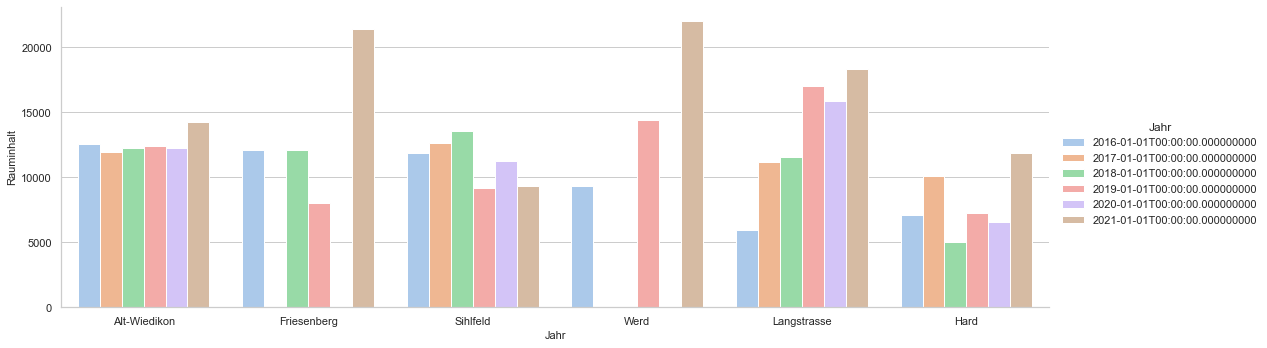

In [46]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(data=data2betested.loc["2016":"2021"].reset_index().query('Quartier_Nummer >30 & Quartier_Nummer < 50 ')
                     , x="Quartier_Name"
            , y="Medianqmp"
            , hue="Jahr"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Rauminhalt', fontsize=11)


In [47]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Anzahl_HAE         object
dtype: object

##### Entwicklung aller Freihandkäufe nach Hauptgrundstücktyp seit 2009

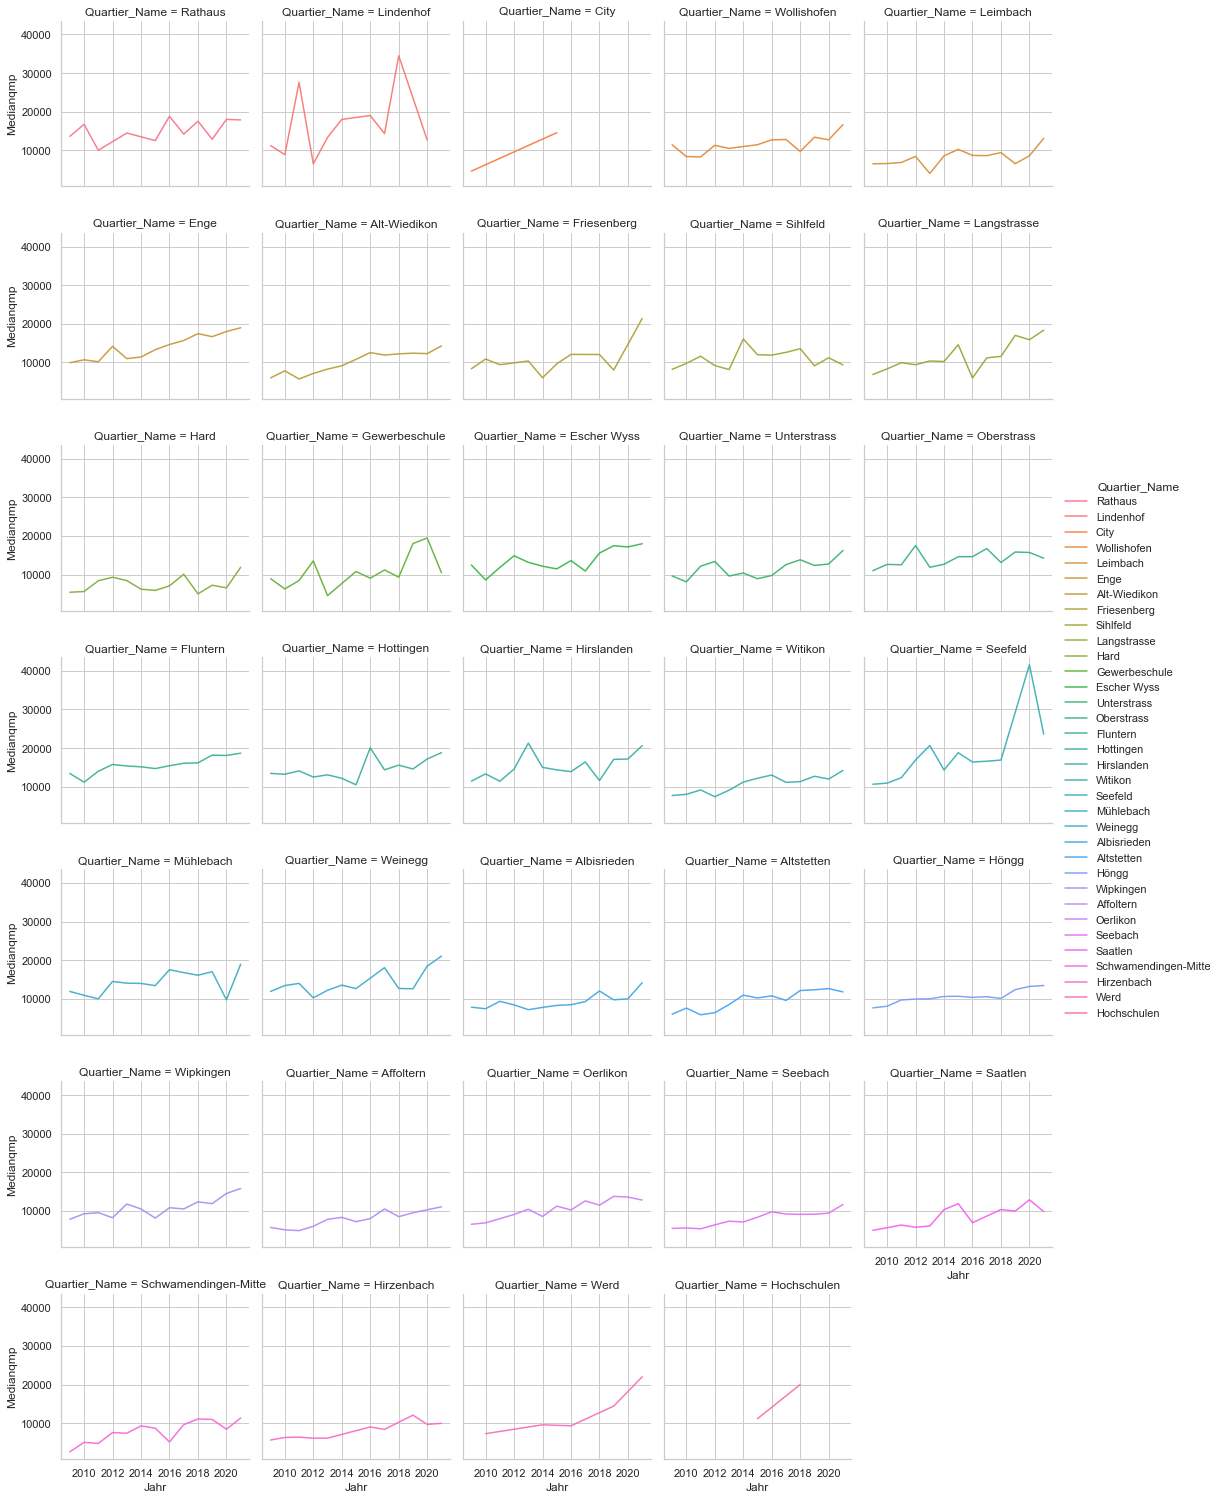

In [55]:
g = sns.FacetGrid(data=data2betested.loc["2009":"2021"].query('Quartier_Nummer > 0').reset_index(), col="Quartier_Name", hue="Quartier_Name", col_wrap=5, height=3)
#g.map(sns.scatterplot, "Jahr", "Medianqmp", alpha=.8)
g.map(sns.lineplot, "Jahr","Medianqmp", alpha=.9)
g.add_legend()



### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Wohnflächenmedianpreise nach Quartier, Jahr und HAnzahl Handänderungen seit 2009

In [56]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Anzahl_HAE         object
dtype: object

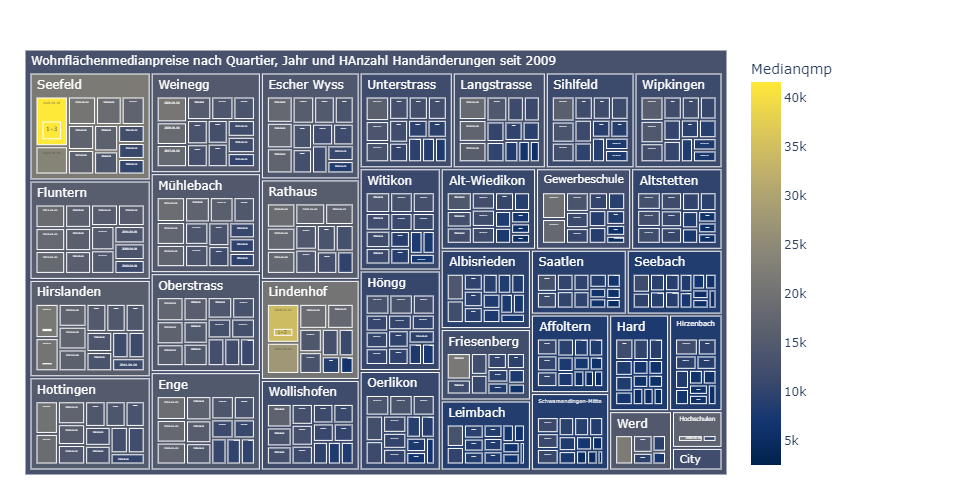

In [59]:
fig = px.treemap(data2betested.reset_index(), path=[px.Constant("Wohnflächenmedianpreise nach Quartier, Jahr und HAnzahl Handänderungen seit 2009")
                                                ,'Quartier_Name','Jahr','Anzahl_HAE']
                 , values='Medianqmp'
                 , color='Medianqmp'               
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                 ,color_continuous_scale='cividis'
                 ,height=500 , width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [63]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=506&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [124]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [115]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [119]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

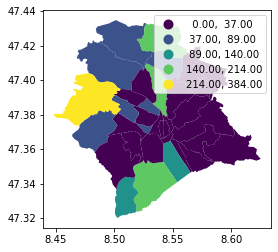

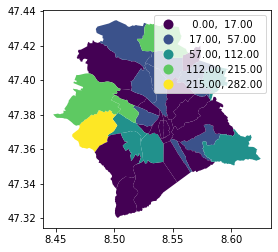

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

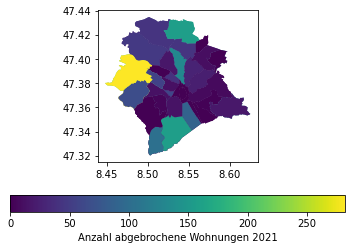

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=506&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**